<img src="https://www.lsce.ipsl.fr/Css/img/banniere_LSCE_75.png" width="600px"> <img src="https://www.ipsl.fr/wp-content/themes/ipsltheme/themes/logo/logo_ipsl_2.png" width="60px">

# Plotting LMDZ outputs with matplotlib and cartopy

## License
This software is governed by the CeCILL license license under French law and abiding by the rules of distribution of free software. You can use, modify and/ or redistribute the software under the terms of the CeCILL license as circulated by CEA, CNRS and INRIA.

Warning, to install, configure, run, use any of Olivier Marti's software or to read the associated documentation you'll need at least one (1) brain in a reasonably working order. Lack of this implement will void any warranties (either express or implied). O. Marti assumes no responsability for errors, omissions, data loss, or any other consequences caused directly or indirectly by the usage of his software by incorrectly or partially configured personal.

## Contact
mailto:olivier.marti@lsce.ipsl.fr

## SVN Information

In [1]:
SVN = { 'Author' : "$Author: $", 'Date' : "$Date: $", 'Revision': "$Revision: $",
        'Id' : "$Id:  $", 'HeadURL' : "$HeadUrl: $" }

# Initialize

## Classic modules

In [2]:
import numpy as np, xarray as xr, xcdat as xc
import matplotlib.pyplot as plt, matplotlib as mpl
import cartopy.mpl.ticker, cartopy.crs as ccrs, cartopy, cartopy.util as cutil
import importlib, sys, os

## Specific module to simplify access to IPSL model outputs

In [3]:
import libIGCM_sys
rad = np.deg2rad (1.0)
Mach = libIGCM_sys.Mach()

In [4]:
print ( 'Machine            : ', Mach                )
print ( 'Version python     : ', sys.version         )
print ( 'Version numpy      : ', np.__version__      )
print ( 'Version xarray     : ', xr.__version__      )
print ( 'Version xcdat      : ', xc.__version__      )
print ( 'Version Matplotlib : ', mpl.__version__     )
print ( 'Version Cartopy    : ', cartopy.__version__ )

Machine            :  Spip
Version python     :  3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:13:44) [Clang 16.0.6 ]
Version numpy      :  1.26.4
Version xarray     :  2024.9.0
Version xcdat      :  0.7.1
Version Matplotlib :  3.9.2
Version Cartopy    :  0.23.0


## Specific module for LMDZ

Use `help(lmdz)` to get some details

In [5]:
import lmdz
importlib.reload (lmdz)
Ra = lmdz.RA
#lmdz.set_options(Debug=True, Stack=True)

# Read and prepare data

In [6]:
mm = libIGCM_sys.Config ( JobName='TR6kCM6AS-Sr01', TagName='IPSLCM6', ExperimentName='Holocene',
                         SpaceName='PROD',
                          #Source='TGCC_thredds', TGCC_User='p86caub', TGCC_Group='gencmip6', 
                         )
mm.Dir    = os.path.join ( mm.R_SAVE, 'ATM', 'Analyse', 'SE' )
mm.Period = 'SE_2000_2099_1M'

In [7]:
f_h = os.path.join ( mm.Dir, f'{mm.JobName}_{mm.Period}_histmth.nc' )

print ( f'{f_h = }' )

f_h = '/Users/marti/Data/IGCM_OUT/IPSLCM6/PROD/Holocene/TR6kCM6AS-Sr01/ATM/Analyse/SE/TR6kCM6AS-Sr01_SE_2000_2099_1M_histmth.nc'


## Open files

In [8]:
#kw = {'chunks':{"time_counter":8}}
kw={}
d_h =  xc.open_dataset (f_h, use_cftime=True, decode_times=False, decode_cf=True, **kw)

## Read variables

In [9]:
t2m      = d_h['t2m']  - lmdz.RT0   # Air temperature : change from °K to °C
temp     = d_h['temp'] - lmdz.RT0
q2m      = d_h['q2m']
psol     = d_h['psol']
pres     = d_h['pres']
presnivs = d_h['presnivs']
u10m     = d_h['u10m']
v10m     = d_h['v10m']
wind10m  = d_h['wind10m']
vitu     = d_h['vitu']
vitv     = d_h['vitv']
vitw     = d_h['vitw']
sst      = (d_h['tsol_oce'] - lmdz.RT0).where ( d_h['pourc_oce']>0, np.nan) # SST : change from °K to °C
rhum     = d_h['rhum']

lon = d_h ['lon'] ; lat = d_h ['lat']

## Standard pressure levels

In [10]:
std_lev = np.array ( [1013, 1000, 975, 950, 925, 900, 875, 850, 825, 
                       800,  750, 700, 650, 600, 550, 500, 450, 400, 350, 300, 250,
                       200,  150, 100,  70,  50,  30,  20,  10]) * 100.

std_lev = xr.DataArray ( std_lev, dims=('pressure',), coords= (std_lev,) )
std_lev.attrs.update ( {'units':'Pa', 'standard_name':'Pressure levels'} )

## Font size for plots

In [11]:
#plt.style.use ("dark_background")
plt.rcParams ['font.size'] = '16'

background = plt.rcParams['figure.facecolor']
foreground = plt.rcParams['lines.color']

### Get logo files

In [12]:
def GetLogo ( url, File='Logo.png' ) : 
    import requests, os
    from pathlib import Path
    File = Path (File)
    if "http" in url : 
        suffix = File.suffix
        if suffix == '' : 
            suffix = '.png'
            File = File + suffix
        if not File.exists () :
            data = requests.get(url).content
            file = open ( f'{File}', 'wb')
            file.write (data)
        Logo = mpl.image.imread ( f'{File}')
    else :
        Logo = mpl.image.imread (url)
    return Logo

# Plots

## Simple time plot

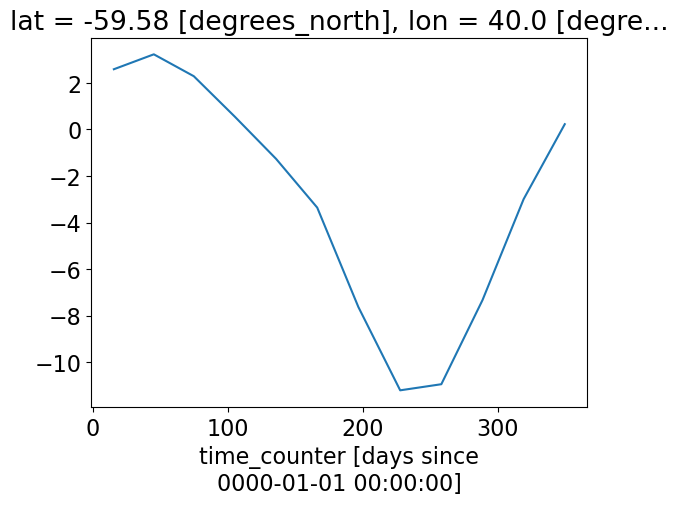

In [13]:
t2m.sel ( {'lat':-60, 'lon':40}, 'nearest' ).plot()

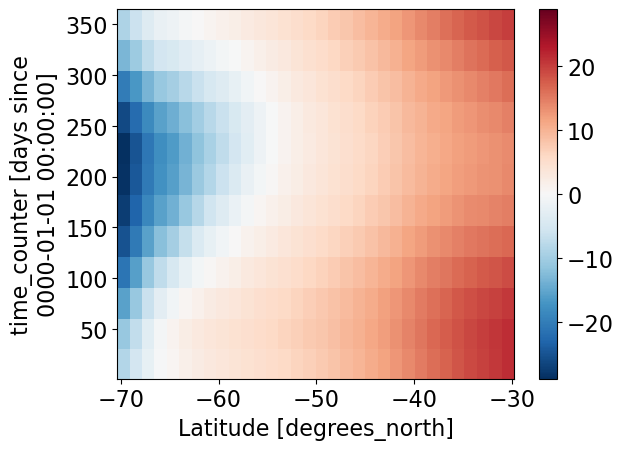

In [14]:
t2m.sel ( {'lat':slice(-30,-70)} ).mean (dim='lon').plot ()

## Scalars

### Robinson

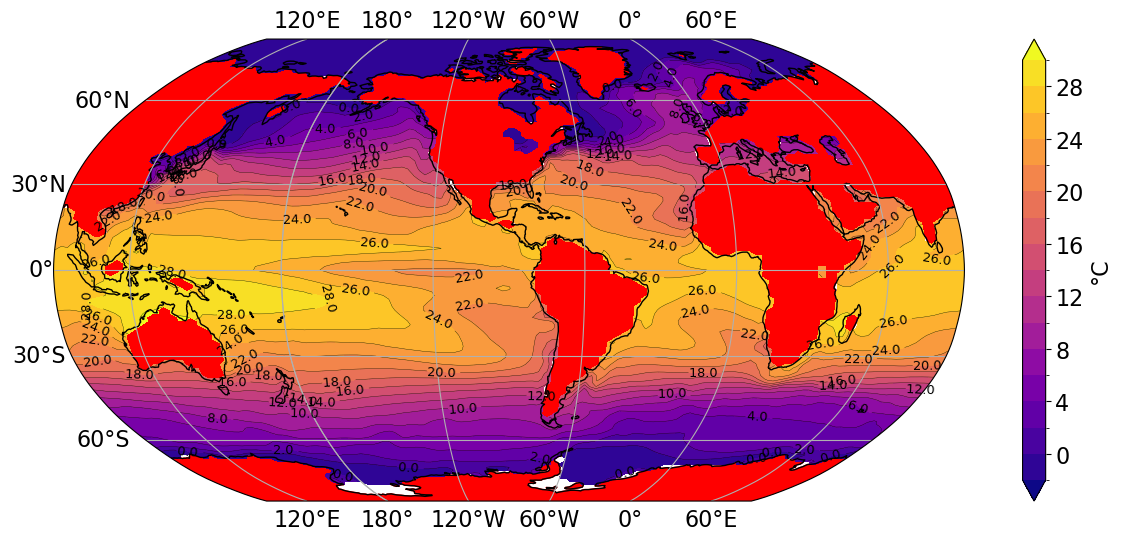

In [15]:
# Creates the color palette
#levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-2, 30)
levels= np.linspace (-2, 30, 17) 
palet  = mpl.cm.plasma
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

# Projection for plots
ProjPlot = ccrs.Robinson (central_longitude=270) # Plotted projection

# Creates the figure
fig, ax = plt.subplots ( figsize=(15,6), subplot_kw={'projection':ProjPlot} )
ax.set_global ()

# Select data
tt, xx, yy = lmdz.add_cyclic (sst[0], lon, lat)

# Color filing
mmap = ax.contourf (xx, yy, tt, 
                    cmap=cmap, norm=norm, levels=levels, transform=ProjIn, extend='both')
    
# Contour lines
mlin = ax.contour (xx, yy, tt, colors='k', levels=levels, transform=ProjIn, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

# Beautify
ax.gridlines (draw_labels=True, crs=ProjIn,)
ax.coastlines ()
ax.add_feature(cartopy.feature.LAND, color='red')

# Color palette
plt.colorbar(mmap, label="°C")



### Orthographic

Text(0.5, 0.98, 'Sea Surface Temperature on LMDZ grid')

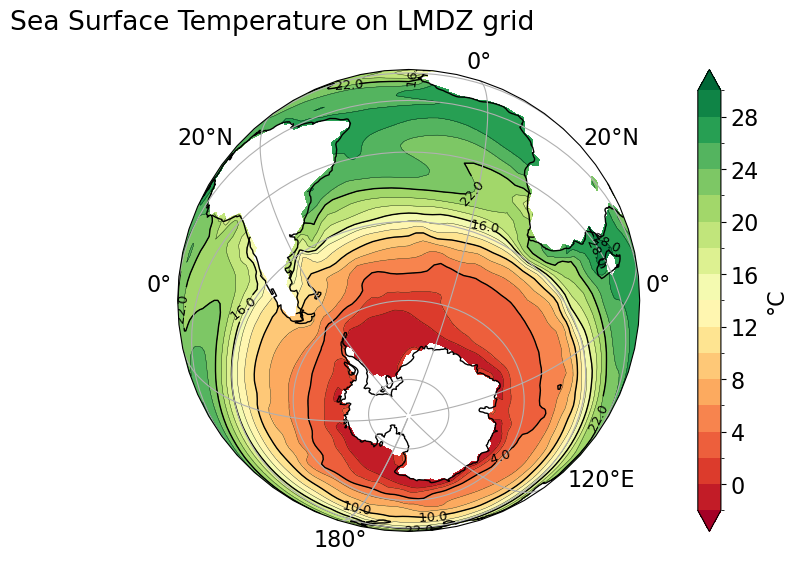

In [16]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-2, 30)
palet  = mpl.cm.RdYlGn
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

# Projection for plots
ProjPlot = ccrs.Orthographic (central_longitude=-20, central_latitude=-60) # Plotted projection

# Creates the figure
fig = plt.figure (figsize=(15,6))

# Creates the viewport, with the associated projection
ax = fig.add_subplot (1, 1, 1, projection=ProjPlot)

ax.set_global ()

# Select data
tt, xx, yy = lmdz.add_cyclic (sst[0], lon, lat)

# Color filing
mmap = ax.contourf ( xx, yy, tt, 
                    cmap=cmap, norm=norm, levels=levels, transform=ProjIn, extend='both')
    
# Contour lines
mlin3 = ax.contour (xx, yy, tt, colors='k', levels=levels[::3], transform=ProjIn, linewidths=1)
mlin  = ax.contour (xx, yy, tt, colors='k', levels=levels, transform=ProjIn, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin3, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

# Beautify
ax.gridlines (draw_labels=True, crs=ProjIn,)
ax.coastlines ()

plt.colorbar ( mmap, label="°C" )

plt.suptitle ( "Sea Surface Temperature on LMDZ grid" )

# Vertical slices

## Zonal mean

Text(0.5, 1.0, 'Latitudinal slice of temperature')

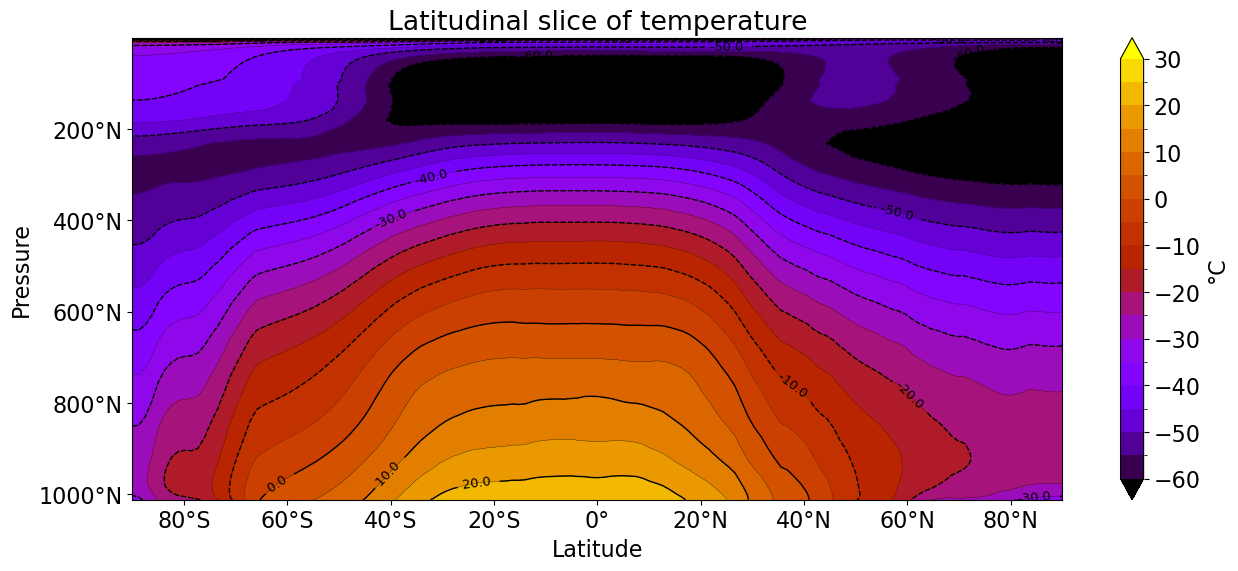

In [17]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=18).tick_values (-60, 30)
palet  = mpl.cm.gnuplot
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Creates the figure
fig = plt.figure (figsize=(15,6))

# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Extract data
tt = temp.isel( time_counter=0 ).mean(dim=['lon',])

# Color filing
mmap = ax.contourf (lat, presnivs/100, tt,
         cmap=cmap, norm=norm, levels=levels, extend='both')

ax.invert_yaxis()
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))
ax.set_xlabel ("Latitude") ; ax.set_ylabel ("Pressure")
ax.yaxis.set_major_formatter (cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

plt.colorbar (mmap, label="°C")

# Contour lines
mlin3 = ax.contour (lat, presnivs/100, tt, colors='k', levels=levels[::2], linewidths=1)
mlin  = ax.contour (lat, presnivs/100, tt, colors='k', levels=levels, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin3, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

ax.set_title ( "Latitudinal slice of temperature" )

### Equator slice

Text(0.5, 1.0, 'Temperature along equator')

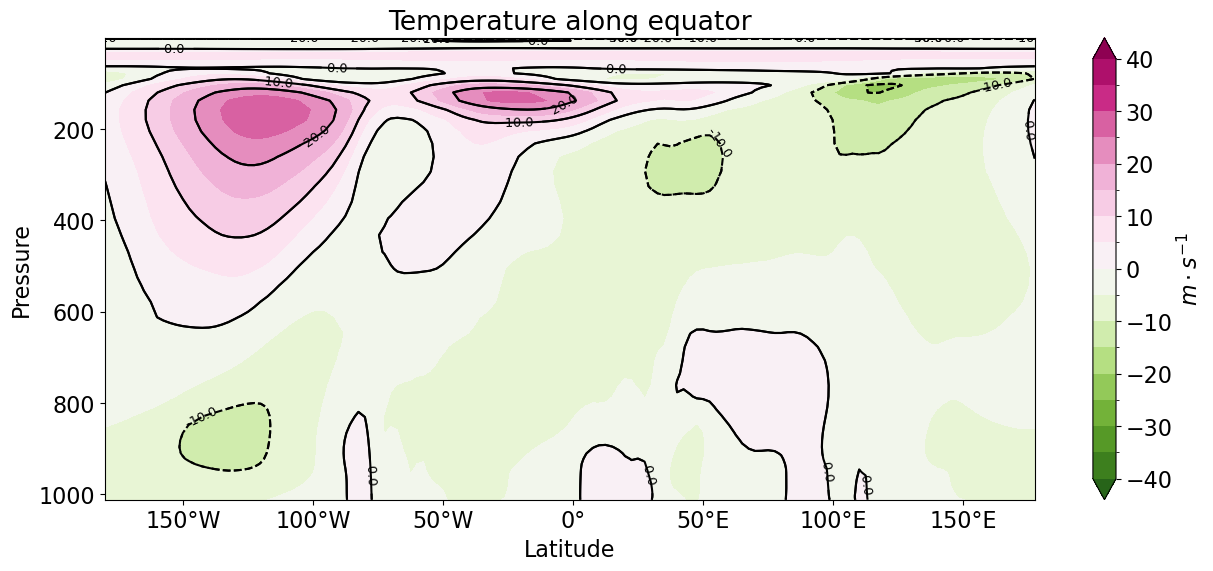

In [18]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-40, 40)
palet  = mpl.cm.PiYG_r
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')
# Creates the figure
fig = plt.figure (figsize=(15,6))

# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Extract data
vu = vitu.isel( time_counter=0 ).sel( {'lat':0} )

# Color filing
mmap = ax.contourf (lon, presnivs/100, vu,
         cmap=cmap, norm=norm, levels=levels, extend='both')

ax.invert_yaxis()
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))
ax.set_xlabel ("Latitude") ; ax.set_ylabel ("Pressure")

plt.colorbar (mmap, label=r"$m \cdot s^{-1}$")

# Contour lines
mlin3 = ax.contour (lon, presnivs/100, vu, colors='k', )#levels=levels[::3], linewidths=1)
mlin  = ax.contour (lon, presnivs/100, vu, colors='k', )#levels=levels, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin3, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

ax.set_title ( "Temperature along equator" )

### Zonal mean on standard pressure levels

/Users/marti/miniforge3/envs/PROD/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


Text(0.5, 1.0, 'Zonal average of vertical velocity')

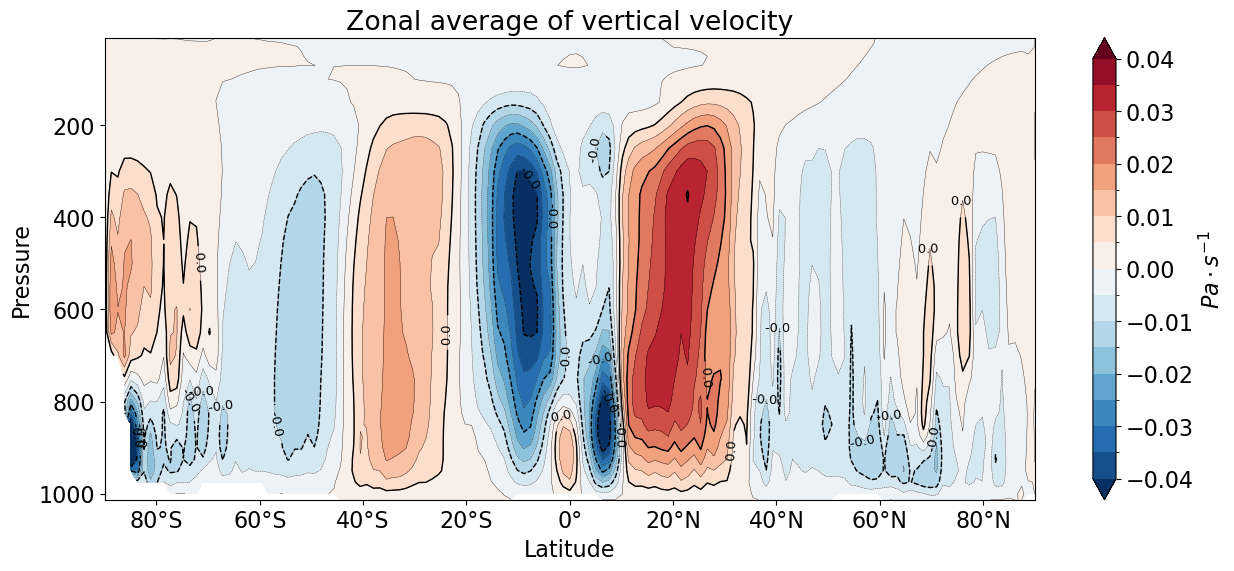

In [19]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-0.040, 0.040)
palet  = mpl.cm.RdBu_r
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Creates the figure
fig = plt.figure (figsize=(15,6))

# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Extract and interpolate data
w1  = vitw.isel(time_counter=0)
xp1 = pres.isel(time_counter=0)

p_grid = xc.regridder.xgcm.Grid (d_h, coords={'presnivs': {'center':'presnivs'}}, periodic=False)
w2 = p_grid.transform (w1, 'presnivs', std_lev, target_data=xp1)
ww = w2.mean(dim=['lon'])

# Color filing
mmap = ax.contourf (lat, std_lev/100, ww.T,
         cmap=cmap, norm=norm, levels=levels, extend='both')

ax.invert_yaxis()
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter(number_format='.0f'))
ax.set_xlabel ("Latitude") ; ax.set_ylabel ("Pressure")

plt.colorbar (mmap, label=r"$Pa \cdot s^{-1}$")

# Contour lines
mlin3 = ax.contour (lat, std_lev/100, ww.T, colors='k', levels=levels[::3], linewidths=1)
mlin  = ax.contour (lat, std_lev/100, ww.T, colors='k', levels=levels, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin3, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

ax.set_title ( "Zonal average of vertical velocity" )

# Winds vectors

## Horizontal maps

### Robinson

/Users/marti/miniforge3/envs/PROD/lib/python3.12/site-packages/cartopy/crs.py:545: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


Text(0.5, 1.0, 'Wind speed @ 10m')

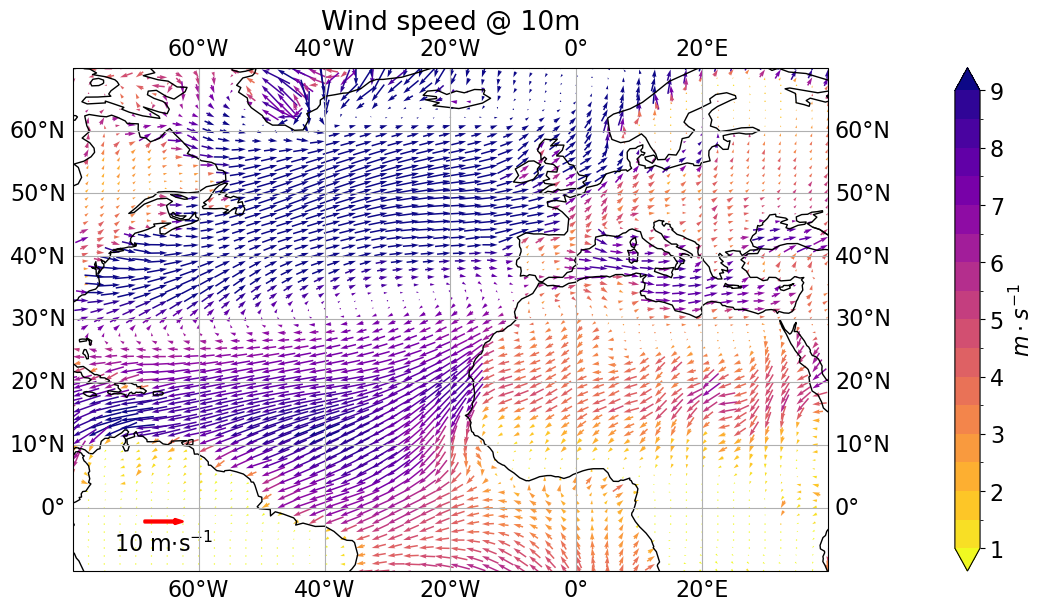

In [20]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (1, 9)
palet  = mpl.cm.plasma_r
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

# Projection for plots
#ProjPlot = ccrs.Robinson (central_longitude=270) # Plotted projection
ProjPlot = ccrs.PlateCarree (central_longitude=270) # Plotted projection


# Creates the figure
fig, ax = plt.subplots ( figsize=(15,6), subplot_kw={'projection':ProjPlot}, layout="constrained")
#ax.set_global ()
ax.set_extent ([-80,40,-10,70], crs=ProjIn)

# Select data
ux = u10m.isel (time_counter=0)
vy = v10m.isel (time_counter=0)
uv = wind10m.isel (time_counter=0)

ux, xx, yy = lmdz.add_cyclic ( u10m   .isel(time_counter=0), lon, lat)
vy, xx, yy = lmdz.add_cyclic ( v10m   .isel(time_counter=0), lon, lat)
uv, xx, yy = lmdz.add_cyclic ( wind10m.isel(time_counter=0), lon, lat)

#
mver = ax.quiver (xx.values, yy.values, ux.values, vy.values, uv.values,
                  pivot='tip', scale=200, width=2E-3, transform=ProjIn,
                  cmap=cmap, norm=norm)

ax.quiverkey (mver, X=0.12, Y=0.1, U=10, label=r'10 m$\cdot$s$^{-1}$', labelpos='S', 
              linewidth=2, color='red')

# Beautify
ax.gridlines (draw_labels=True, crs=ProjIn,)
ax.coastlines ()
plt.colorbar (mver, label=r"$m \cdot s^{-1}$")

ax.set_title ( "Wind speed @ 10m" )

### Orthographic

Text(0.5, 1.0, 'Wind speed @ 10m')

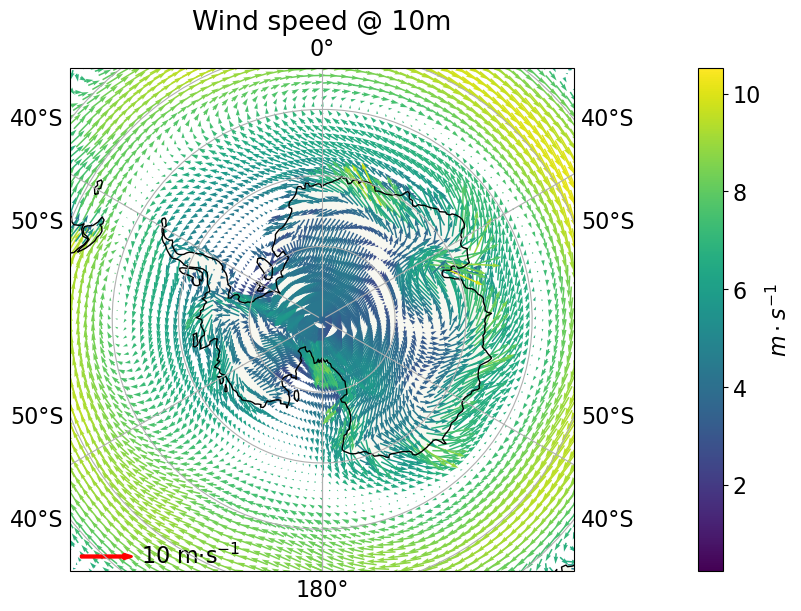

In [21]:
# Describe the model projection in the file
ProjIn = ccrs.PlateCarree ( central_longitude=0) 

# Projection for plots
ProjPlot = ccrs.Orthographic (central_latitude=-90, central_longitude=0) # Plotted projection

# Creates the figure
fig, ax = plt.subplots ( figsize=(15,6), subplot_kw={'projection':ProjPlot}, layout='constrained' )

ux = u10m.isel(time_counter=0)
vy = v10m.isel(time_counter=0)
uv = wind10m.isel(time_counter=0)

# Select data
ux, xx, yy = lmdz.add_cyclic ( u10m.isel(time_counter=0), lon, lat)
vy, xx, yy = lmdz.add_cyclic ( v10m.isel(time_counter=0), lon, lat)
uv, xx, yy = lmdz.add_cyclic ( wind10m.isel(time_counter=0), lon, lat)

# Correct a Cartopy bug in Orthographic projection. See help(lmdz.correct_uv) for details
ux, vy = lmdz.correct_uv (ux, vy, xx, yy)

# Plot vectors
mver = ax.quiver (xx.values, yy.values, ux.values, vy.values, uv.values,
                  pivot='tail', scale=100, width=3E-3, transform=ProjIn )

ax.quiverkey (mver, X=0.12, Y=0.03, U=10, label=r'10 m$\cdot$s$^{-1}$', labelpos='E', 
              linewidth=2, color='red')

# Set plot limits 
width = 0.6 ; ax.set_xlim (-lmdz.RA*width, lmdz.RA*width) ; ax.set_ylim (-lmdz.RA*width, lmdz.RA*width)

# Beautify
ax.coastlines ()
ax.add_feature (cartopy.feature.LAND, alpha=0.4)
ax.gridlines (draw_labels=True, crs=ProjIn,)

# Color palette
plt.colorbar (mver, ax=ax, label=r"$m \cdot s^{-1}$" )

ax.set_title ( "Wind speed @ 10m" )

## Zonal mean

/Users/marti/miniforge3/envs/PROD/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


Text(0.5, 1.0, 'LMDZ Zonal mean of velocity, colored by relative humidity')

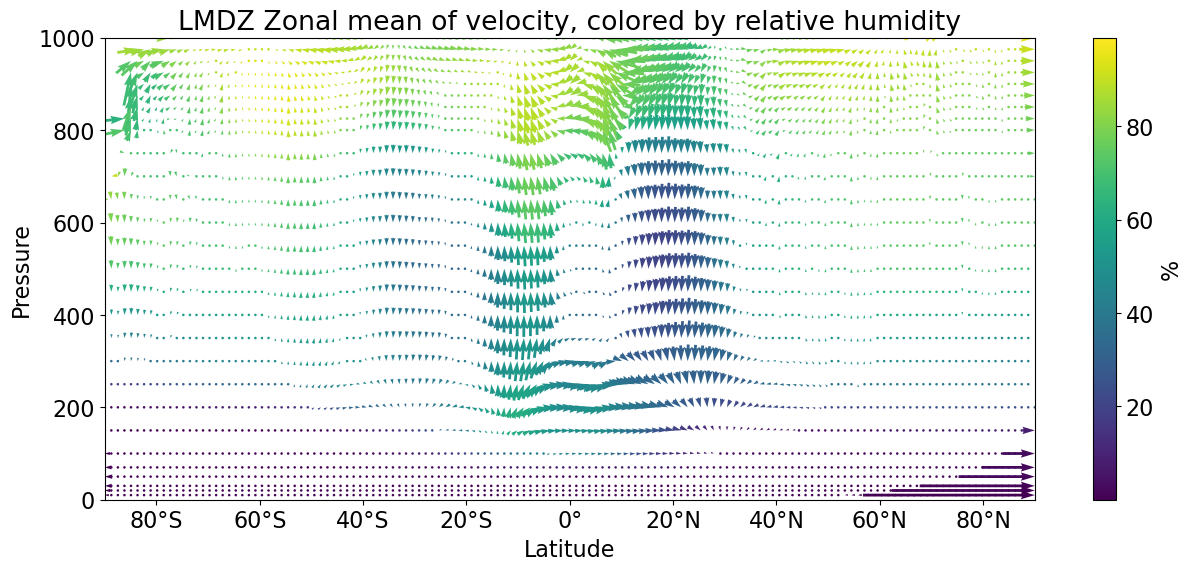

In [22]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-0.040, 0.040)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Creates the figure
fig = plt.figure (figsize=(15,6))

# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Select data
vy, xx, yy = lmdz.add_cyclic ( vitv.isel(time_counter=0), lon, lat)
wz, xx, yy = lmdz.add_cyclic ( vitw.isel(time_counter=0), lon, lat)
tt, xx, yy = lmdz.add_cyclic ( temp.isel(time_counter=0), lon, lat)
pp, xx, yy = lmdz.add_cyclic ( pres.isel(time_counter=0), lon, lat)
rr, xx, yy = lmdz.add_cyclic ( rhum.isel(time_counter=0), lon, lat)

# Interpolate data
p_grid = xc.regridder.xgcm.Grid (d_h, coords={'presnivs': {'center':'presnivs'}}, periodic=False)
vyp = p_grid.transform (vy, 'presnivs', std_lev, target_data=pp)
wzp = p_grid.transform (wz, 'presnivs', std_lev, target_data=pp)
ttp = p_grid.transform (tt, 'presnivs', std_lev, target_data=pp)
rrp = p_grid.transform (rr, 'presnivs', std_lev, target_data=pp)

# Zonal mean
vyp_m = vyp.mean (dim=['lon']).T
wzp_m = wzp.mean (dim=['lon']).T
ttp_m = ttp.mean (dim=['lon']).T
rrp_m = rrp.mean (dim=['lon']).T
pp_m  = pp.mean  (dim=['lon']).T
rr_m  = rr.mean  (dim=['lon']).T

# Computes scale factors to get correct direction of vectors
ax.set_ylim (1000,0) ; ax.set_xlim (-90, 90)
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
delta_Y = ax.get_window_extent().height
delta_X = ax.get_window_extent().width
fact_v  = delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w  = delta_Y / np.abs(ymax-ymin)

# Plot vectors
aa, bb = np.meshgrid (yy, std_lev/100)
mver = ax.quiver (aa, bb, vyp_m, -wzp_m*fact_w/fact_v/100, rrp_m*100,
                  pivot='tip', scale=150, width=3E-3)

ax.invert_yaxis()
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter(number_format='.0f'))
ax.set_xlabel ("Latitude") ; ax.set_ylabel ("Pressure")

plt.colorbar (mver, label="%", ax=ax)

ax.set_title ( "LMDZ Zonal mean of velocity, colored by relative humidity" )

## Equatorial section

/Users/marti/miniforge3/envs/PROD/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


Text(0.5, 1.0, 'LMDZ wind along equator, colored by temperature')

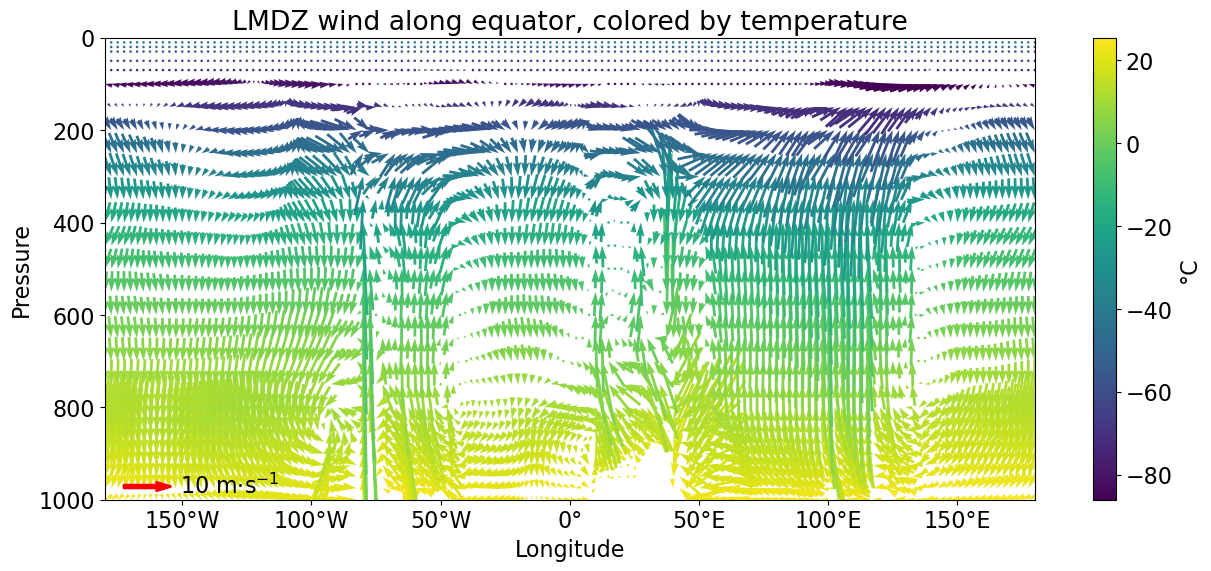

In [23]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-0.040, 0.040)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Creates the figure
fig = plt.figure (figsize=(15,6))

# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Select data
ux, xx, yy = lmdz.add_cyclic ( vitv.isel(time_counter=0).sel(lat=0), lon, lat)
wz, xx, yy = lmdz.add_cyclic ( vitw.isel(time_counter=0).sel(lat=0), lon, lat)
tt, xx, yy = lmdz.add_cyclic ( temp.isel(time_counter=0).sel(lat=0), lon, lat)
pp, xx, yy = lmdz.add_cyclic ( pres.isel(time_counter=0).sel(lat=0), lon, lat)

# Interpolate data
p_grid = xc.regridder.xgcm.Grid (d_h, coords={'presnivs': {'center':'presnivs'}}, periodic=False)
uxp = p_grid.transform (ux, 'presnivs', std_lev, target_data=pp).T
wzp = p_grid.transform (wz, 'presnivs', std_lev, target_data=pp).T
ttp = p_grid.transform (tt, 'presnivs', std_lev, target_data=pp).T
rrp = p_grid.transform (rr, 'presnivs', std_lev, target_data=pp).T

# Computes scale factors to get correct direction of vectors
ax.set_ylim (0,1000) ; ax.set_xlim (-180, 180)
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
delta_Y = ax.get_window_extent().height
delta_X = ax.get_window_extent().width
fact_u  = delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w  = delta_Y / np.abs(ymax-ymin)

# Plot vectors
aa, bb = np.meshgrid (xx, std_lev/100)
mver = ax.quiver (aa, bb, uxp, -(wzp*fact_w/fact_u)/100, ttp,
                  pivot='tip', scale=200, width=3E-3)

ax.quiverkey (mver, X=0.07, Y=0.03, U=10, label=r'10 m$\cdot$s$^{-1}$', labelpos='E', 
              linewidth=2, color='red')

ax.invert_yaxis()
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))
ax.set_xlabel ("Longitude") ; ax.set_ylabel ("Pressure")

plt.colorbar (mver, label="°C")

ax.set_title ( "LMDZ wind along equator, colored by temperature")

# Streamlines

## Robinson

Text(0.5, 1.0, 'LMDZ wind, colored by relative humidity')

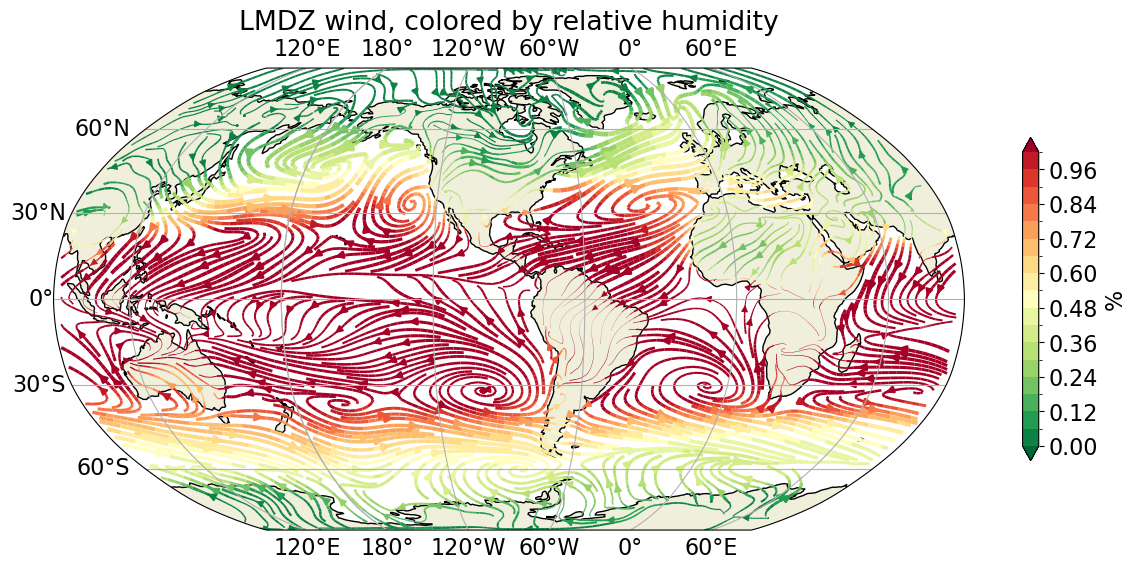

In [24]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (0, 1)
palet  = mpl.cm.RdYlGn_r
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')
# Describe the model projection in the file
ProjIn   = ccrs.PlateCarree (central_longitude=0)

# Projection for plots
ProjPlot = ccrs.Robinson (central_longitude=270)

# Define the figure
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot (1, 1, 1, projection=ProjPlot)

# Select data
ux, xx, yy = lmdz.add_cyclic (u10m.isel(time_counter=0), lon, lat)
vy, xx, yy = lmdz.add_cyclic (v10m.isel(time_counter=0), lon, lat)
uv, xx, yy = lmdz.add_cyclic (wind10m.isel(time_counter=0), lon, lat)
tt, xx, yy = lmdz.add_cyclic (t2m.isel(time_counter=0), lon, lat)
qq, xx, yy = lmdz.add_cyclic (q2m.isel(time_counter=0), lon, lat)


# Plot the stream lines
col = ax.streamplot ( xx.values, yy.values, ux.values, vy.values,
                     transform=ProjIn, density=4, color=qq.values*100,
                     linewidth=uv.values*0.3,
                     cmap=cmap, norm=norm)

# Beautify
ax.set_global ()
ax.coastlines ()
ax.gridlines  (draw_labels=True, crs=ProjIn)
ax.add_feature (cartopy.feature.LAND, zorder=0)

# Colorbar
plt.colorbar (col.lines, orientation='vertical', ax=fig.axes, label='%', shrink=0.7)

ax.set_title ( "LMDZ wind, colored by relative humidity" )

## Orthographic

Text(0.5, 1.0, 'LMDZ wind, colored by temperature')

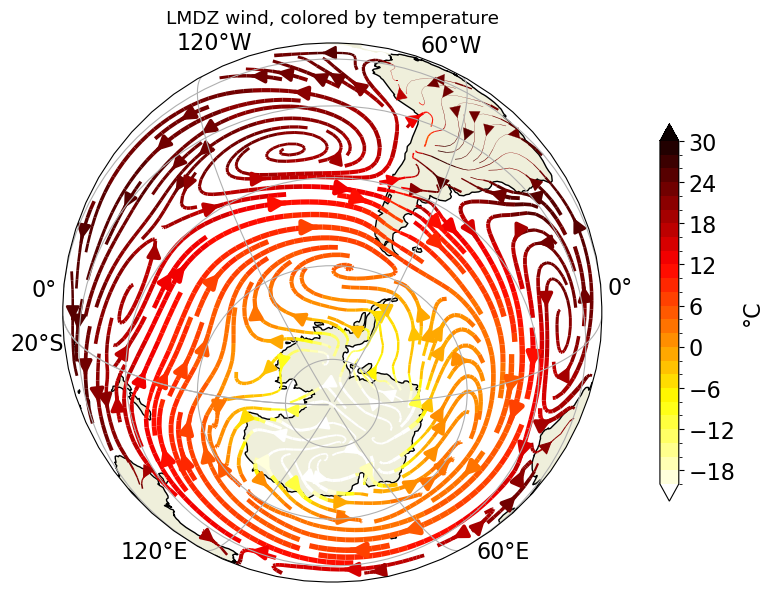

In [25]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=33).tick_values (-20, 30)
palet  = mpl.cm.hot_r
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Describe the model projection in the file
ProjIn   = ccrs.PlateCarree (central_longitude=0)

# Projection for plots
ProjPlot = ccrs.Orthographic (central_latitude=-70, central_longitude=270)

# Create the figure
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot (1, 1, 1, projection=ProjPlot)

# Select data
ux, xx, yy = lmdz.add_cyclic ( u10m.isel(time_counter=0)   , lon, lat)
vy, xx, yy = lmdz.add_cyclic ( v10m.isel(time_counter=0)   , lon, lat)
uv, xx, yy = lmdz.add_cyclic ( wind10m.isel(time_counter=0), lon, lat)
tt, xx, yy = lmdz.add_cyclic ( t2m.isel(time_counter=0)    , lon, lat)

yy, xx = xr.broadcast (yy, xx)

# Correct a Cartopy bug in Orthographic projection. See help(lmdz.correct_uv) for details
ux, vy = lmdz.correct_uv ( ux, vy, xx, yy)

# Streamplot in orthographic needs to have limits on region
jmin=60 ; jmax=lat.shape[0]

col = ax.streamplot (xx[jmin:jmax].values, yy[jmin:jmax].values, 
                     ux[jmin:jmax].values, vy[jmin:jmax].values,
                     transform=ProjIn, density=2, cmap=cmap, norm=norm,
                     color    = tt[jmin:jmax].values,
                     linewidth=uv[jmin:jmax].values*0.4, arrowsize=2)

# Set plot limits 
width = 1; ax.set_xlim (-Ra*width, Ra*width) ; ax.set_ylim (-Ra*width, Ra*width)

# Beautify
ax.coastlines ()
ax.gridlines  (draw_labels=True, crs=ProjIn)
ax.add_feature (cartopy.feature.LAND, zorder=0)

plt.colorbar (col.lines, orientation='vertical', ax=fig.axes, label='°C', shrink=0.7)

ax.set_title ( "LMDZ wind, colored by temperature", fontsize="small" )

## Zonal mean

/Users/marti/miniforge3/envs/PROD/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/Users/marti/miniforge3/envs/PROD/lib/python3.12/site-packages/matplotlib/colors.py:1353: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/marti/miniforge3/envs/PROD/lib/python3.12/site-packages/matplotlib/colors.py:1360: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


Text(0.5, 1.0, 'LMDZ wind, colored by relative humidty')

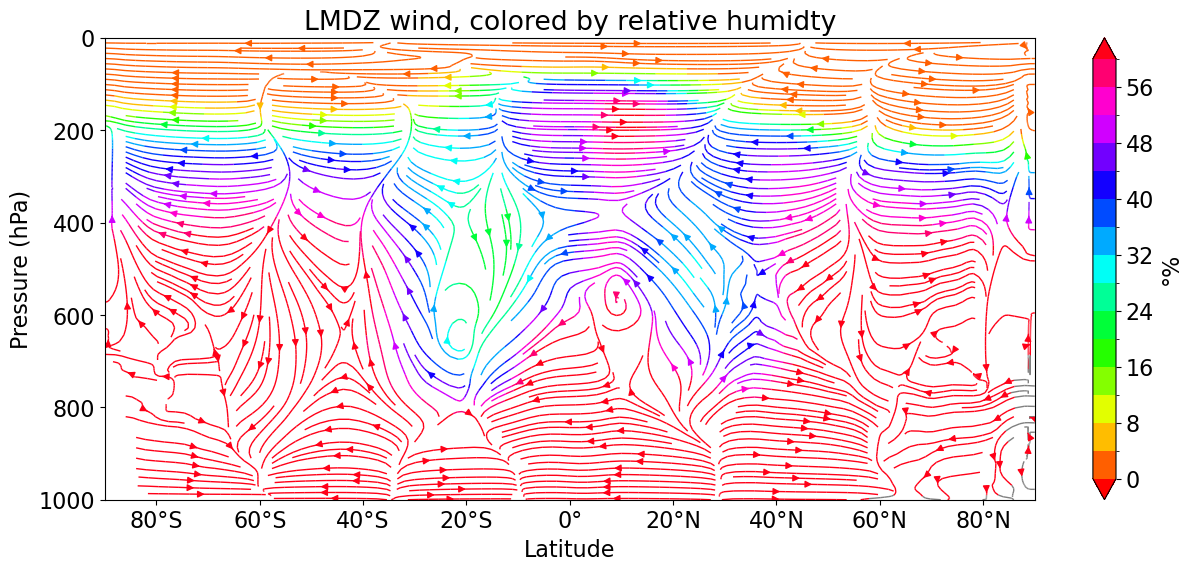

In [26]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (0, 60)
palet  = mpl.cm.hsv
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Creates the figure
fig = plt.figure (figsize=(15,6))

# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Select data
vy, xx, yy = lmdz.add_cyclic (vitv.isel(time_counter=0), lon, lat)
wz, xx, yy = lmdz.add_cyclic (vitw.isel(time_counter=0), lon, lat)
tt, xx, yy = lmdz.add_cyclic (temp.isel(time_counter=0), lon, lat)
rr, xx, yy = lmdz.add_cyclic (rhum.isel(time_counter=0), lon, lat)
pp, xx, yy = lmdz.add_cyclic (pres.isel(time_counter=0), lon, lat)

# Interpolate data on regular pressure lev
reg_lev = np.linspace (0, 1000, 100) * 100
reg_lev = xr.DataArray (reg_lev, dims=('pressure'), coords=(reg_lev,))
lev_grid = xc.regridder.xgcm.Grid (d_h, coords={'presnivs': {'center':'presnivs'}}, periodic=False)
vyp = p_grid.transform (vy, 'presnivs', reg_lev, target_data=pp).T
wzp = p_grid.transform (wz, 'presnivs', reg_lev, target_data=pp).T
ttp = p_grid.transform (tt, 'presnivs', reg_lev, target_data=pp).T
rrp = p_grid.transform (rr, 'presnivs', reg_lev, target_data=pp).T

# Zonal mean
vyp_m = vyp.mean (dim=['lon'])
wzp_m = wzp.mean (dim=['lon'])
ttp_m = ttp.mean (dim=['lon'])
rrp_m = rrp.mean (dim=['lon'])
pp_m  = pp.mean  (dim=['lon'])

# Revert latitudes
yy = yy[::-1]
vyp_m = vyp_m [:, ::-1]
wzp_m = wzp_m [:, ::-1]
ttp_m = ttp_m [:, ::-1]

# Computes scale factors to get correct direction of vectors
ax.set_ylim (1000,0) ; ax.set_xlim (-90, 90)
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
delta_Y = ax.get_window_extent().height
delta_X = ax.get_window_extent().width
fact_v  = delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w  = delta_Y / np.abs(ymax-ymin)

# Plot vectors
aa, bb = np.meshgrid (yy, reg_lev/100)

mcol = ax.streamplot (aa, bb, vyp_m.values, (-wzp_m*fact_w/fact_v/100).values,
                      density=3, color=rrp_m.values*100, cmap=cmap, norm=norm,
                      linewidth=1, arrowsize=1)

ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter(number_format='.0f'))
ax.set_xlabel ("Latitude") ; ax.set_ylabel ("Pressure (hPa)")

plt.colorbar (mcol.lines, label="°%")

ax.set_title ( "LMDZ wind, colored by relative humidty" )

## Equatorial section

/Users/marti/miniforge3/envs/PROD/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


Text(0.5, 1.0, 'LMDZ wind, colored by temperature')

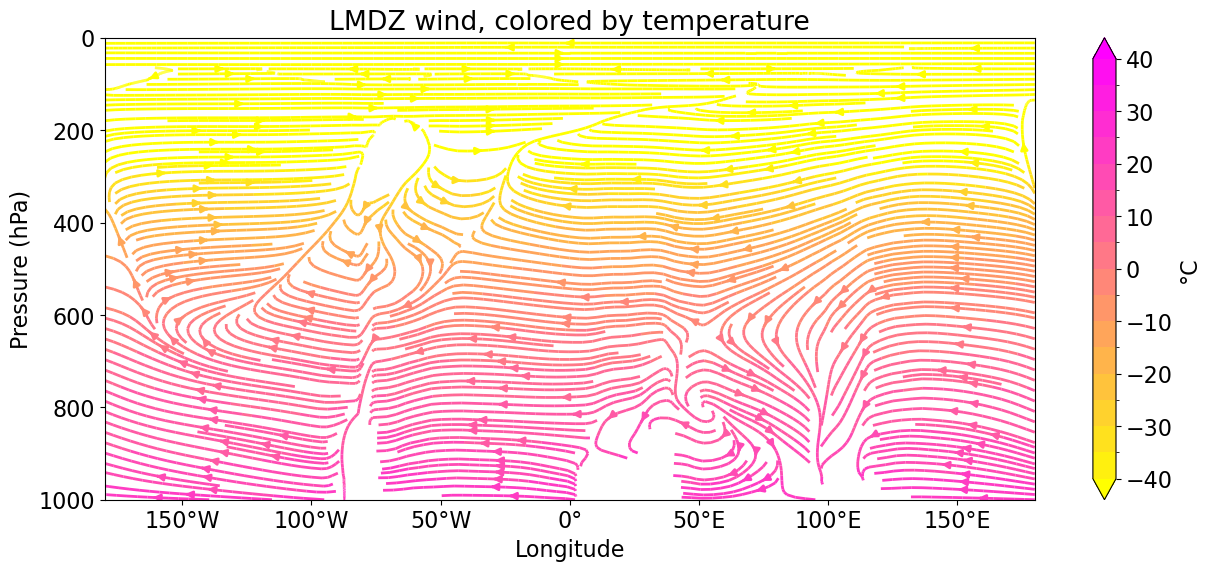

In [27]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-40, 40)
palet  = mpl.cm.spring_r
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Creates the figure
fig = plt.figure (figsize=(15,6))

# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Select data
ux, xx, yy = lmdz.add_cyclic (vitu.isel(time_counter=0).sel(lat=0), lon, lat)
wz, xx, yy = lmdz.add_cyclic (vitw.isel(time_counter=0).sel(lat=0), lon, lat)
tt, xx, yy = lmdz.add_cyclic (temp.isel(time_counter=0).sel(lat=0), lon, lat)
pp, xx, yy = lmdz.add_cyclic (pres.isel(time_counter=0).sel(lat=0), lon, lat)

# Interpolate data on regular pressure lev
reg_lev = np.linspace (0, 1000, 100) * 100
reg_lev = xr.DataArray (reg_lev, dims=('pressure'), coords=(reg_lev,))
lev_grid = xc.regridder.xgcm.Grid (d_h, coords={'presnivs': {'center':'presnivs'}}, periodic=False)
uxp = p_grid.transform (ux, 'presnivs', reg_lev, target_data=pp).T
wzp = p_grid.transform (wz, 'presnivs', reg_lev, target_data=pp).T
ttp = p_grid.transform (tt, 'presnivs', reg_lev, target_data=pp).T
rrp = p_grid.transform (rr, 'presnivs', reg_lev, target_data=pp).T


# Computes scale factors to get correct direction of vectors
ax.set_ylim (1000,0) ; ax.set_xlim (-180, 180)
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
delta_Y = ax.get_window_extent().height
delta_X = ax.get_window_extent().width
fact_v  = delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w  = delta_Y / np.abs(ymax-ymin)

# Plot vectors
aa, bb = np.meshgrid (xx, reg_lev/100)
mcol = ax.streamplot (aa, bb, uxp.values, (-wzp*fact_w/fact_v/100).values,
                     density=3, color = ttp.values, 
                     linewidth=2, arrowsize=1,
                     cmap=cmap, norm=norm)

ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter (number_format='.0f'))
ax.set_xlabel ("Longitude") ; ax.set_ylabel ("Pressure (hPa)")

plt.colorbar (mcol.lines, label="°C", ax=ax)

ax.set_title ( "LMDZ wind, colored by temperature" )

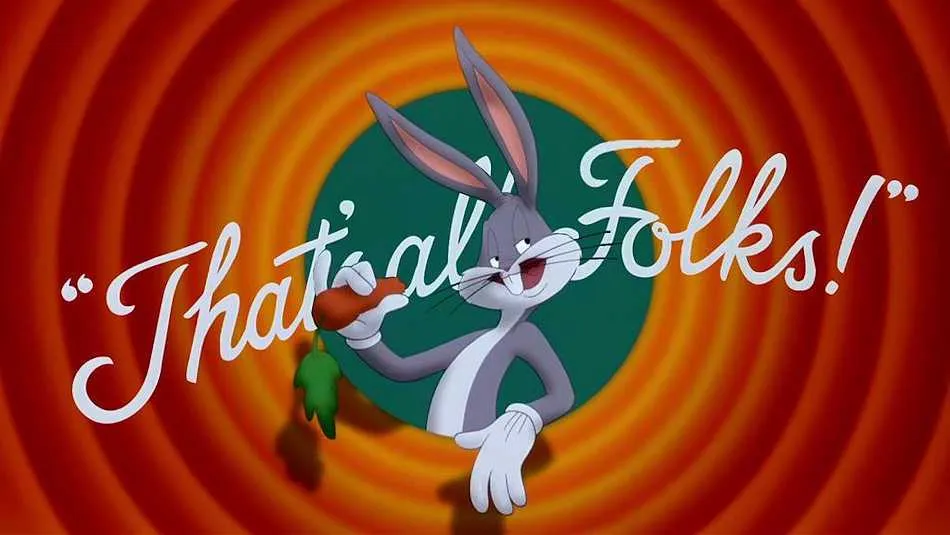

In [28]:
import requests
from IPython.display import Image

Bunny = GetLogo ("https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F2f95d3fe-13e7-4220-84b1-9c12d760f233_950x535.jpeg"
, 'Bugs_Bunny.jpeg')

Image (filename='Bugs_Bunny.jpeg', width=600)